# Weighted K-Means Clustering

In this exercise we will simulate finding good locations for production plants of a company in order to minimize its logistical costs. In particular, we would like to place production plants near customers so as to reduce shipping costs and delivery time.

We assume that the probability of someone being a customer is independent of its geographical location and that the overall cost of delivering products to customers is proportional to the squared Euclidean distance to the closest production plant. Under these assumptions, the K-Means algorithm is an appropriate method to find a good set of locations. Indeed, K-Means finds a spatial clustering of potential customers and the centroid of each cluster can be chosen to be the location of the plant.

Because there are potentially millions of customers, and that it is not scalable to model each customer as a data point in the K-Means procedure, we consider instead as many points as there are geographical locations, and assign to each geographical location a weight $w_i$ corresponding to the number of inhabitants at that location. The resulting problem becomes a weighted version of K-Means where we seek to minimize the objective:

$$
J(c_1,\dots,c_K) = \frac{\sum_{i} w_i \min_k ||x_i-c_k||^2}{\sum_{i} w_i},
$$

where $c_k$ is the $k$th centroid, and $w_i$ is the weight of each geographical coordinate $x_i$. In order to minimize this cost function, we iteratively perform the following EM computations:

* **Expectation step:** Compute the set of points associated to each centroid:
$$
\forall~1 \leq k \leq K: \quad \mathcal{C}(k) \leftarrow \Big\{ i ~:~ k = \mathrm{arg}\min_k \| x_i - c_k \|^2 \Big\}
$$


* **Minimization step:** Recompute the centroid as a the (weighted) mean of the associated data points:
$$
\forall~1 \leq k \leq K: \quad c_k \leftarrow \frac{\sum_{i \in \mathcal{C}(k)} w_i \cdot x_i}{\sum_{i \in \mathcal{C}(k)} w_i}
$$


until the objective $J(c_1,\dots,c_K)$ has converged.


## Getting started

In this exercise we will use data from http://sedac.ciesin.columbia.edu/, that we store in the files `data.mat` as part of the zip archive. The data contains for each geographical coordinates (latitude and longitude), the number of inhabitants and the corresponding country. Several variables and methods are provided in the file `utils.py`:


*  **`utils.population`** A 2D array with the number of inhabitants at each latitude/longitude.


*  **`utils.plot(latitudes,longitudes)`** Plot a list of centroids given as geographical coordinates in overlay to the population density map.

The code below plots three factories (white squares) with geographical coordinates (60,80),
(60,90),(60,100) given as input.

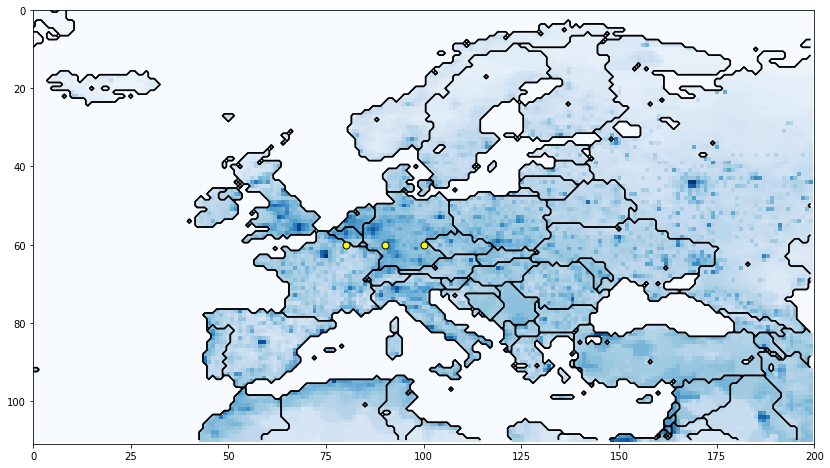

In [1]:
import utils, numpy as np, math
%matplotlib inline
utils.plot([60,60,60],[80,90,100])

Also, to get a dataset of geographical coordinates associated to the image given as an array, we can use:

In [2]:
x,y = np.indices(utils.population.shape)
locations = np.array([x.flatten(),y.flatten()]).T

## Initializing Weighted K-Means (25 P)

Because K-means has a non-convex objective, choosing a good initial set of centroids is important. Centroids are drawn from from the following discrete probability distribution:

$$
P(x,y) = \frac1Z \cdot \text{population}(x,y)
$$

where $Z$ is a normalization constant. Furthermore, to avoid identical centroids, we add a small Gaussian noise to the location of centroids, with standard deviation $0.01$.

**Task:**

* **Implement the initialization procedure above.**

In [3]:
#K: number of centroids
#Population: 111 (0 - 110 lat) x 200 (0 - 199 long) array

def initialize(K,population):
     
     Probability = population.flatten()
     Probability = Probability / np.sum(Probability)

     locations = np.arange(0,len(Probability))
     
     #one column with all the longitudes, another with all the latitudes
     Lats, Longs = [], []
     noises = np.random.normal(1, 0.01, K)
     for k in range(K):

          pos = np.random.choice(locations, p=Probability)

          noise = noises[k]
          lat = min(max(0,math.floor(pos/200)),110)
          long = min(max(0,math.floor(pos%200)),200)
          
          Lats.append(min( max(0,round(noise*lat)), 110) )
          Longs.append(min( max(0,round(noise*long)), 200) )

     centroids = np.array([Lats, Longs]).T

     return centroids

The following code runs the initialization procedure for K=200 clusters and visualizes the centroids obtained with the initialization procedure using `utils.plot`.

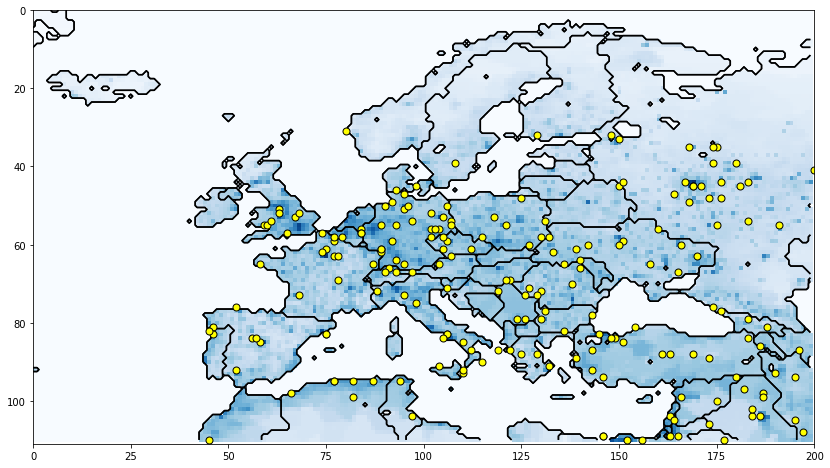

In [4]:
centroids_init = initialize(200, utils.population)
utils.plot(centroids_init[:,0], centroids_init[:,1])

## Implementing Weighted K-Means (75 P)

**Task:**


* **Implement the weighted K-Means algorithm. Your algorithm should run for `nbit` iterations and print the value of the objective after training. If `verbose`, it should also print the value of the objective at each iteration.**

In [8]:
#centroids: 200 (K centroids) x 2 (lat, long)
#points: 22200 (111x200 locations) x 2 (lat, long)
#weights: 22200 locations x 1 weight
def wkmeans(centroids, points, weights, verbose, nbit):

    #We keep the meaningful points to reduce the time
    threshold = np.mean(weights)/10
    J_old = 0

    #For every iteration
    for i in range(nbit):

        #Initialize clusters and J
        Clusters  = {}
        for j in range(len(centroids)): Clusters[j] = []

        #Go through every point assigning cluster
        for j in range(len(points)):

                point, weight = points[j], weights[j]
                
                if weight > threshold:
            
                    cluster, loss = -1, math.inf

                    #find the distance to each centroid
                    for k in range(len(centroids)):

                        centroid = centroids[k]
                        weight2 = weights[centroid[0]*200 + centroid[1]]
                        
                        #using the inverse gravitational force formula if it decreases update cluster and loss
                        loss2 = np.linalg.norm(centroid - point)**2 / ( weight * weight2)

                        if loss2 < loss : cluster, loss = k, loss2

                    Clusters[cluster] += [j]
       
        #Go through every cluster assigning centroid
        J=0
        for j in range(len(centroids)):

            cluster = Clusters[j]
            Losses = dict.fromkeys(cluster, 0)

            #For every element we find its J
            for k in range(len(cluster)):
                
                pos = cluster[k]
                point, weight = points[pos], weights[pos]
                
                #Against every element
                for l in range(k+1,len(cluster)):
                    
                    pos2 = cluster[l]
                    point2, weight2 = points[pos2], weights[pos2]

                    loss = np.linalg.norm(point2 - point)**2 / (weight * weight2)
                    Losses[pos] += loss
                    Losses[pos2] += loss

            centroid_pos = min(Losses, key = Losses.get)
            centroids[j] = points[centroid_pos]
            J += Losses[centroid_pos]

        if J_old == J :
            print("It:",i+1,"; J:", J)
            break
        
        if verbose:
            print("It:",i+1,"; J:", J)

        J_old = J
            
        
    return centroids

The following code runs the weighted k-means on this data, and displays the final centroids.

It: 1 ; J: 0.35077092875526833
It: 2 ; J: 0.34969236148886296
It: 3 ; J: 0.3482870988299673
It: 4 ; J: 0.34519223055344905
It: 5 ; J: 0.3437754675230636
It: 6 ; J: 0.3431273823563462
It: 7 ; J: 0.34306388911313723
It: 8 ; J: 0.3430238381259994
It: 9 ; J: 0.3430238381259994


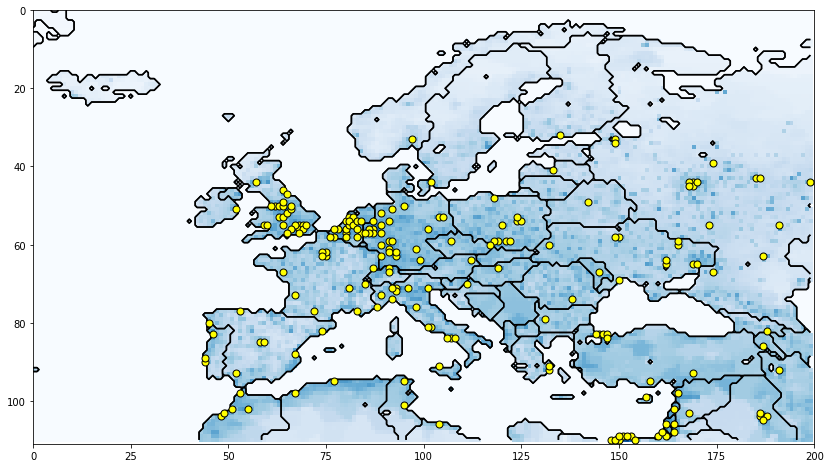

In [8]:
weights   = utils.population.flatten()*1.0

centroids = wkmeans(centroids_init, locations, weights, True, 50)

utils.plot(centroids[:,0], centroids[:,1])

Observe that the k-means algorithm is non-convex, and arrives in local optima of different quality depending on the initialization:

In [9]:
for i in range(5):
    wkmeans(initialize(200, utils.population), locations, weights, False, 50)

It: 9 ; J: 0.3430238381259994
It: 8 ; J: 0.33693164646749163
It: 9 ; J: 0.3430238381259994
It: 7 ; J: 0.33497115379243225
It: 10 ; J: 0.34493575883749644
